# Wavelet analysis and forged banknotes: Supervised ML  - Classification

The objectives of the project:

**A.** Train numerous classifier models belonging to four categories (Logistic Regression, K-Nearest Neighbor, Support Vector Machines and Decision Trees) that can predict if a banknote is genuine or not based on the dataset from OpenML containing wavelet analysis results for genuine and forged banknotes.

**B.** Comparing the models' performance metrics to enable selecting the best model for the task. 

## 1. The data

### 1.1. Description & exploration

The dataset originates from OpenML and contains wavelet analysis results for genuine and forged banknotes. The authors describe it as follows: 

*Dataset about distinguishing genuine and forged banknotes. Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. A Wavelet Transform tool was used to extract features from these images* [https://www.openml.org/search?type=data&sort=runs&id=1462&status=active]. 

Data reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The data table contains 4 columns with parameters from wavelet analysis (V1 – variance of Wavelet Transformed image, V2 – skewness of Wavelet Transformed image, V3 – curtosis of Wavelet Transformed image, V4 – entropy of image) and Class column describing if the banknote is genuine (1) or forged (2). There are 762 rows for genuine banknotes and 610 rows for forged ones.

In [1]:
# Data import
import pandas as pd
data = pd.read_csv('Banknote-authentication-dataset.csv')
print(data)

           V1        V2       V3       V4  Class
0     3.62160   8.66610  -2.8073 -0.44699      1
1     4.54590   8.16740  -2.4586 -1.46210      1
2     3.86600  -2.63830   1.9242  0.10645      1
3     3.45660   9.52280  -4.0112 -3.59440      1
4     0.32924  -4.45520   4.5718 -0.98880      1
...       ...       ...      ...      ...    ...
1367  0.40614   1.34920  -1.4501 -0.55949      2
1368 -1.38870  -4.87730   6.4774  0.34179      2
1369 -3.75030 -13.45860  17.5932 -2.77710      2
1370 -3.56370  -8.38270  12.3930 -1.28230      2
1371 -2.54190  -0.65804   2.6842  1.19520      2

[1372 rows x 5 columns]


In [2]:
# Genuine and forged count
data.Class.value_counts()

1    762
2    610
Name: Class, dtype: int64

In [3]:
# Summary statistics
data.describe()

,V1,V2,V3,V4,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,1.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,1.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,1.000000
50%,0.496180,2.319650,0.616630,-0.586650,1.000000
75%,2.821475,6.814625,3.179250,0.394810,2.000000
max,6.824800,12.951600,17.927400,2.449500,2.000000


In [4]:
data.isnull().any()

V1       False
V2       False
V3       False
V4       False
Class    False
dtype: bool

<AxesSubplot:>

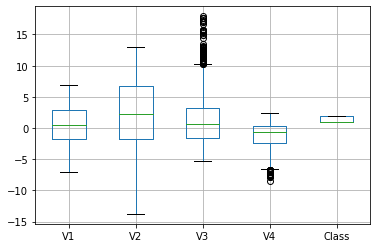

In [5]:
# Boxplot for outliers inspection
data.boxplot()

The data is good quality - there are no gaps or Not-a-Numbers and the calculated summary statistics look reasonable. There are no actual outliers (single data points far away from the rest of the dataset), but V3 and V4 data have some "tails".

### 1.2. Data preparation

The data was normalized to the range between 0 and 1 and absolute value correlation matrix was calculated (see below).

In [6]:
# Normalization (0 - 1)
col_names = data.columns
from sklearn import preprocessing
data = pd.DataFrame(preprocessing.minmax_scale(data, feature_range=(0, 1), axis=0, copy=True))
data.columns = col_names
data.Class = data.Class.astype(int)
data

,V1,V2,V3,V4,Class
0,0.769004,0.839643,0.106783,0.736628,0
1,0.835659,0.820982,0.121804,0.644326,0
2,0.786629,0.416648,0.310608,0.786951,0
3,0.757105,0.871699,0.054921,0.450440,0
4,0.531578,0.348662,0.424662,0.687362,0
...,...,...,...,...,...
1367,0.537124,0.565855,0.165249,0.726398,1
1368,0.407690,0.332868,0.506753,0.808350,1
1369,0.237385,0.011768,0.985603,0.524755,1
1370,0.250842,0.201701,0.761587,0.660675,1


In [7]:
# Correlation matrix - absolute values
corr = abs(data.corr())
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\bewer\AppData\Local\Temp/ipykernel_15884/1874121638.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,V1,V2,V3,V4,Class
V1,1.00,0.26,0.38,0.28,0.72
V2,0.26,1.00,0.79,0.53,0.44
V3,0.38,0.79,1.00,0.32,0.16
V4,0.28,0.53,0.32,1.00,0.02
Class,0.72,0.44,0.16,0.02,1.00


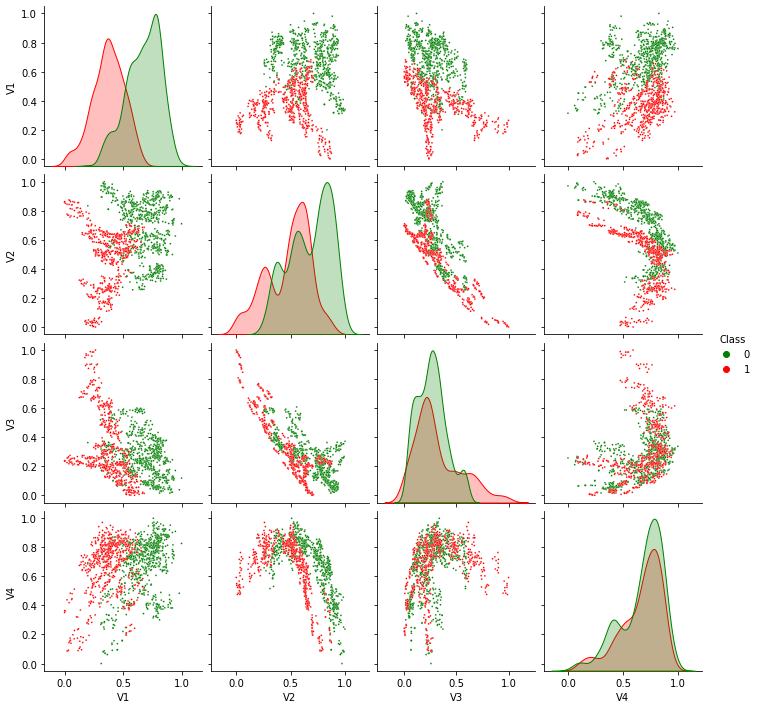

In [8]:
# visual check of the correlations between the variables - pairplot
import seaborn as sns
sns.pairplot(data, hue='Class', palette={0:'green',1:'red'}, plot_kws={"s": 3})

There is strong correlation (0.72) between V1 and Class, so V1 will be an important variable for the predictions. Correlation between the remaining parameters and Class is weaker: 0.44 for V2, 0.16 for V3 and only 0.02 for V4. This excludes V4 from useful parameters. There is also strong correlation (0.79) between V2 and V3. The correlation values are calculated considering linear correlation, but the correlations are actually non-linear. V3 will stay in the dataset for the calculations even though others could think of removing V3 as it is more linearly correlated with V2 than with Class (linear correlation is not everything). Classes are not easily separable in any of 2D plots. V2, V3 and V4 seem to be non-linearly correlated with each other, so it may be beneficial to get rid of one of them and stay with just three variables. The datapoints for different classes are least separable in V3-V4 plots, so there is no reason to use these variables together. Distribution of genuine and forged banknotes data overlaps the most on the V4 plot. To summarize, it can be deduced from the above, that V4 could be dropped.

In [9]:
# Deleting V4
data.drop(['V4'], axis=1, inplace=True)
data

,V1,V2,V3,Class
0,0.769004,0.839643,0.106783,0
1,0.835659,0.820982,0.121804,0
2,0.786629,0.416648,0.310608,0
3,0.757105,0.871699,0.054921,0
4,0.531578,0.348662,0.424662,0
...,...,...,...,...
1367,0.537124,0.565855,0.165249,1
1368,0.407690,0.332868,0.506753,1
1369,0.237385,0.011768,0.985603,1
1370,0.250842,0.201701,0.761587,1


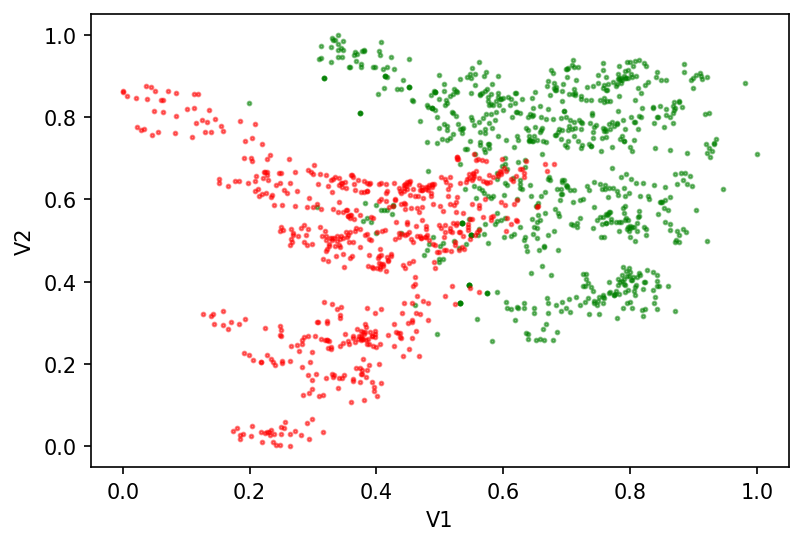

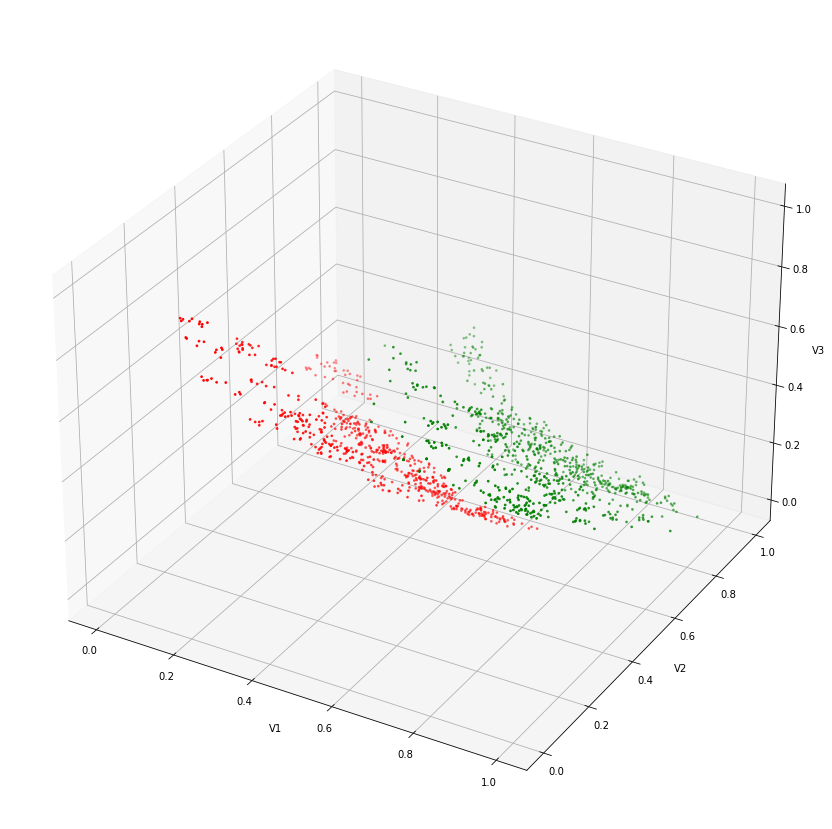

In [10]:
import matplotlib.pyplot as plt

# V1 vs. V2: genuine and forged plot
plt.figure(dpi=150)
plt.xlabel('V1')
plt.ylabel('V2')
plt.scatter(data[data['Class'] == 0]['V1'], data[data['Class'] == 0]['V2'], s=3, color='green', alpha=0.5)
plt.scatter(data[data['Class'] == 1]['V1'], data[data['Class'] == 1]['V2'], s=3, color='red', alpha=0.5)
plt.show()

# 3D plot of genuine and forged
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[data['Class'] == 0]['V1'], data[data['Class'] == 0]['V2'], data[data['Class'] == 0]['V3'],
          s=3, color='green')
ax.scatter(data[data['Class'] == 1]['V1'], data[data['Class'] == 1]['V2'], data[data['Class'] == 1]['V3'],
          s=3, color='red')
plt.xlabel('V1')
plt.ylabel('V2')
ax.set_zlabel('V3')
plt.show()

The plots above shows genuine (green) and forged (red) banknotes data with respect to V1, V2 and V3 values.It is clearly visible, that there is an area in 2D plot where red and green points overlap – this part of the data would be very challenging for classifier models not utilizing V3 parameter.

The task was to train a model that can predict if a banknote is genuine or not, so training data and test data were needed. Train-test split was performed using Scikit-learn's StratifiedShuffleSplit (to maintain the same ratio of predictor classes) with 10 folds to ensure that the split result does not determine model performance.

In [11]:
# Train-test split
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 10

strat_shuf_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)
indexes = pd.DataFrame(strat_shuf_split.split(data[data.columns[:-1]], data.Class))
indexes.rename(columns = {0:'train_idx', 1:'test_idx'}, inplace = True)

indexes

,train_idx,test_idx
0,"[905, 3, 256, 46, 282, 900, 1058, 107, 1207, 1...","[388, 47, 916, 277, 1354, 878, 1222, 423, 510,..."
1,"[1229, 352, 682, 1213, 83, 876, 930, 983, 606,...","[272, 738, 102, 1234, 1135, 127, 95, 317, 279,..."
2,"[558, 1301, 1327, 1337, 44, 848, 1291, 983, 13...","[920, 636, 946, 248, 481, 750, 306, 326, 510, ..."
3,"[1318, 80, 1197, 303, 247, 970, 1342, 218, 545...","[1215, 863, 998, 600, 455, 1164, 809, 329, 98,..."
4,"[1249, 1067, 534, 545, 998, 617, 877, 84, 1224...","[881, 912, 381, 1337, 347, 474, 855, 20, 48, 3..."
5,"[36, 1244, 66, 435, 637, 606, 977, 80, 318, 71...","[991, 723, 1361, 1306, 759, 1286, 1126, 691, 2..."
6,"[898, 248, 1228, 655, 1319, 393, 522, 331, 253...","[1028, 953, 1087, 206, 25, 225, 102, 724, 82, ..."
7,"[1214, 174, 357, 238, 1310, 997, 71, 226, 904,...","[1136, 855, 917, 384, 399, 452, 1230, 421, 102..."
8,"[717, 989, 196, 1310, 408, 436, 1166, 853, 933...","[1262, 164, 1305, 1338, 92, 784, 309, 623, 130..."
9,"[525, 409, 314, 1120, 1136, 920, 205, 596, 301...","[1019, 92, 272, 918, 513, 820, 1239, 671, 126,..."


## 2. Classifier models

### 2.1. Logistic regression

Three logistic regression models (Standard logistic regression model as well as L1 and L2 regularized logistic regression models with Cs=10 and cv=4) were trained.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
#import statistics as st
import numpy as np

scores_columns = ["acccuracy_lr", "precision_lr", "recall_lr", "f1_lr", "acccuracy_lr_l1", "precision_lr_l1", 
                  "recall_lr_l1", "f1_lr_l1", "acccuracy_lr_l2", "precision_lr_l2", "recall_lr_l2", "f1_lr_l2"]
scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')

for i in range(0, n_splits):
    X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
    X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]

    # Standard logistic regression
    lr = LogisticRegression(solver='liblinear', max_iter=1000000).fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    scores.acccuracy_lr[i] = accuracy_score(y_test, y_pred)
    scores.precision_lr[i] = precision_score(y_test, y_pred)
    scores.recall_lr[i] = recall_score(y_test, y_pred)
    scores.f1_lr[i] = f1_score(y_test, y_pred)
    
    # L1 regularized logistic regression
    lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=1000000).fit(X_train, y_train)
    y_pred = lr_l1.predict(X_test)
    scores.acccuracy_lr_l1[i] = accuracy_score(y_test, y_pred)
    scores.precision_lr_l1[i] = precision_score(y_test, y_pred)
    scores.recall_lr_l1[i] = recall_score(y_test, y_pred)
    scores.f1_lr_l1[i] = f1_score(y_test, y_pred)
    
    # L2 regularized logistic regression
    lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', max_iter=1000000).fit(X_train, y_train)
    y_pred = lr_l2.predict(X_test)
    scores.acccuracy_lr_l2[i] = accuracy_score(y_test, y_pred)
    scores.precision_lr_l2[i] = precision_score(y_test, y_pred)
    scores.recall_lr_l2[i] = recall_score(y_test, y_pred)
    scores.f1_lr_l2[i] = f1_score(y_test, y_pred)
    
scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(3,4)), 
                              index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'),
                              columns=('lr', 'lr_l1', 'lr_l2'), dtype='float')

scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(3,4)), 
                              index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'),
                              columns=('lr', 'lr_l1', 'lr_l2'), dtype='float')
del scores_columns, scores

scores_SD_summary = pd.concat([scores_summary, scores_SD])

del scores_summary, scores_SD

scores_SD_summary


,lr,lr_l1,lr_l2
mean accuracy,0.970290,0.992754,0.992754
mean precision,0.972363,0.988838,0.988838
mean recall,0.960656,0.995082,0.995082
mean f1,0.966069,0.991882,0.991882
accuracy SD,0.012738,0.008574,0.008574
precision SD,0.019217,0.015968,0.015968
recall SD,0.028583,0.007512,0.007512
f1 SD,0.015014,0.009542,0.009542


### 2.2. K-Nearest Neighbor

Ten K-Nearest Neighbor (KNN) models were trained with k values from 1 to 10.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
k_values = range(1,11)

for k in k_values:
    
    scores_columns = ["acccuracy", "precision", "recall", "f1"]
    scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')

    for i in range(0, n_splits):
        X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
        X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]
    
        # KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn = knn.fit(X_train, y_train)
        y_pred= knn.predict(X_test)
    
        scores.acccuracy[i] = accuracy_score(y_test, y_pred)
        scores.precision[i] = precision_score(y_test, y_pred)
        scores.recall[i] = recall_score(y_test, y_pred)
        scores.f1[i] = f1_score(y_test, y_pred)
    
    scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(1,4)), 
                                  index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'), dtype='float')
    
    scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(1,4)), 
                             index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'), dtype='float')

    scores_SD_summary[f'KNN k={k}'] = pd.concat([scores_summary, scores_SD])

del scores, scores_summary, scores_SD

scores_SD_summary

,lr,lr_l1,lr_l2,KNN k=1,KNN k=2,KNN k=3,KNN k=4,KNN k=5,KNN k=6,KNN k=7,KNN k=8,KNN k=9,KNN k=10
mean accuracy,0.970290,0.992754,0.992754,0.997826,0.997826,0.997101,0.997826,0.997101,0.997101,0.994203,0.995652,0.996377,0.995652
mean precision,0.972363,0.988838,0.988838,0.995161,0.995161,0.993548,0.995161,0.993548,0.995161,0.988812,0.991987,0.991987,0.991987
mean recall,0.960656,0.995082,0.995082,1.000000,1.000000,1.000000,1.000000,1.000000,0.998361,0.998361,0.998361,1.000000,0.998361
mean f1,0.966069,0.991882,0.991882,0.997561,0.997561,0.996748,0.997561,0.996748,0.996735,0.993509,0.995122,0.995948,0.995122
accuracy SD,0.012738,0.008574,0.008574,0.003321,0.003321,0.003550,0.003321,0.003550,0.003550,0.005423,0.004807,0.004861,0.004807
precision SD,0.019217,0.015968,0.015968,0.007391,0.007391,0.007902,0.007391,0.007902,0.007391,0.012427,0.010706,0.010706,0.010706
recall SD,0.028583,0.007512,0.007512,0.000000,0.000000,0.000000,0.000000,0.000000,0.004918,0.004918,0.004918,0.000000,0.004918
f1 SD,0.015014,0.009542,0.009542,0.003726,0.003726,0.003983,0.003726,0.003983,0.004000,0.006046,0.005374,0.005425,0.005374


### 2.3. Support Vector Machines

Thirteen Support Vector Machines (SVM) models were trained. One with linear decision boundary and twelve with Gaussian kernel and combinations of the parameters from: gammas = [0.5, 1, 2, 10], Cs = [0.1, 1, 10].

In [14]:
# SVM: Linear Decision Boundary
from sklearn.svm import LinearSVC
LSVC = LinearSVC()

scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')

for i in range(0, n_splits):
    X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
    X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]

    LSVC = LSVC.fit(X_train, y_train)
    y_pred = LSVC.predict(X_test)
    
    scores.acccuracy[i] = accuracy_score(y_test, y_pred)
    scores.precision[i] = precision_score(y_test, y_pred)
    scores.recall[i] = recall_score(y_test, y_pred)
    scores.f1[i] = f1_score(y_test, y_pred)

scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(1,4)), 
                              index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'), dtype='float')

scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(1,4)), 
                              index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'), dtype='float')

scores_SD_summary['SVM:LSVC'] = pd.concat([scores_summary, scores_SD])

del scores, scores_summary, scores_SD

In [15]:
# SVM: Gaussian kernel
from sklearn.svm import SVC

gammas = [0.5, 1, 2, 10] 
Cs = [0.1, 1, 10]


for gamma in gammas:
    for C in Cs:
        
        svc = SVC(kernel='rbf', gamma=gamma, C=C)
        scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')
        
        for i in range(0, n_splits):
            X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
            X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]

            svc.fit(X_train, y_train)
            y_pred= svc.predict(X_test)
    
            scores.acccuracy[i] = accuracy_score(y_test, y_pred)
            scores.precision[i] = precision_score(y_test, y_pred)
            scores.recall[i] = recall_score(y_test, y_pred)
            scores.f1[i] = f1_score(y_test, y_pred)

        scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(1,4)), 
                                  index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'), dtype='float')

        scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(1,4)), 
                                  index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'), dtype='float')

        scores_SD_summary[f'SVM: gamma={gamma}, C={C}'] = pd.concat([scores_summary, scores_SD])

        del scores, scores_summary, scores_SD
        
scores_SD_summary

,lr,lr_l1,lr_l2,KNN k=1,KNN k=2,KNN k=3,KNN k=4,KNN k=5,KNN k=6,KNN k=7,...,"SVM: gamma=0.5, C=10","SVM: gamma=1, C=0.1","SVM: gamma=1, C=1","SVM: gamma=1, C=10","SVM: gamma=2, C=0.1","SVM: gamma=2, C=1","SVM: gamma=2, C=10","SVM: gamma=10, C=0.1","SVM: gamma=10, C=1","SVM: gamma=10, C=10"
mean accuracy,0.970290,0.992754,0.992754,0.997826,0.997826,0.997101,0.997826,0.997101,0.997101,0.994203,...,0.992029,0.984058,0.989130,0.994928,0.985507,0.989130,1.0,0.985507,0.994928,0.997826
mean precision,0.972363,0.988838,0.988838,0.995161,0.995161,0.993548,0.995161,0.993548,0.995161,0.988812,...,0.982460,0.965572,0.976262,0.988761,0.968600,0.976262,1.0,0.968600,0.988812,0.995161
mean recall,0.960656,0.995082,0.995082,1.000000,1.000000,1.000000,1.000000,1.000000,0.998361,0.998361,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
mean f1,0.966069,0.991882,0.991882,0.997561,0.997561,0.996748,0.997561,0.996748,0.996735,0.993509,...,0.991109,0.982387,0.987922,0.994322,0.983961,0.987922,1.0,0.983961,0.994335,0.997561
accuracy SD,0.012738,0.008574,0.008574,0.003321,0.003321,0.003550,0.003321,0.003550,0.003550,0.005423,...,0.006019,0.009051,0.007425,0.004640,0.008574,0.007425,0.0,0.008574,0.005660,0.003321
precision SD,0.019217,0.015968,0.015968,0.007391,0.007391,0.007902,0.007391,0.007902,0.007391,0.012427,...,0.012998,0.019357,0.016012,0.010224,0.018447,0.016012,0.0,0.018447,0.012427,0.007391
recall SD,0.028583,0.007512,0.007512,0.000000,0.000000,0.000000,0.000000,0.000000,0.004918,0.004918,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
f1 SD,0.015014,0.009542,0.009542,0.003726,0.003726,0.003983,0.003726,0.003983,0.004000,0.006046,...,0.006650,0.009950,0.008198,0.005179,0.009455,0.008198,0.0,0.009455,0.006306,0.003726


### 2.4. Decision Trees

Two decision three models were trained: one with and one without use of grid search.

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')

for i in range(0, n_splits):
    X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
    X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]

    dt = dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    
    scores.acccuracy[i] = accuracy_score(y_test, y_pred)
    scores.precision[i] = precision_score(y_test, y_pred)
    scores.recall[i] = recall_score(y_test, y_pred)
    scores.f1[i] = f1_score(y_test, y_pred)
    print(f'nodes:{dt.tree_.node_count}, depth:{dt.tree_.max_depth}')

scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(1,4)), 
                              index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'), dtype='float')

scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(1,4)), 
                              index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'), dtype='float')

scores_SD_summary['Decision Tree'] = pd.concat([scores_summary, scores_SD])

del scores, scores_summary, scores_SD

scores_SD_summary

nodes:55, depth:9
nodes:47, depth:8
nodes:47, depth:8
nodes:53, depth:8
nodes:45, depth:8
nodes:53, depth:8
nodes:41, depth:8
nodes:49, depth:8
nodes:45, depth:8
nodes:55, depth:8


,lr,lr_l1,lr_l2,KNN k=1,KNN k=2,KNN k=3,KNN k=4,KNN k=5,KNN k=6,KNN k=7,...,"SVM: gamma=1, C=0.1","SVM: gamma=1, C=1","SVM: gamma=1, C=10","SVM: gamma=2, C=0.1","SVM: gamma=2, C=1","SVM: gamma=2, C=10","SVM: gamma=10, C=0.1","SVM: gamma=10, C=1","SVM: gamma=10, C=10",Decision Tree
mean accuracy,0.970290,0.992754,0.992754,0.997826,0.997826,0.997101,0.997826,0.997101,0.997101,0.994203,...,0.984058,0.989130,0.994928,0.985507,0.989130,1.0,0.985507,0.994928,0.997826,0.986957
mean precision,0.972363,0.988838,0.988838,0.995161,0.995161,0.993548,0.995161,0.993548,0.995161,0.988812,...,0.965572,0.976262,0.988761,0.968600,0.976262,1.0,0.968600,0.988812,0.995161,0.979306
mean recall,0.960656,0.995082,0.995082,1.000000,1.000000,1.000000,1.000000,1.000000,0.998361,0.998361,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.991803
mean f1,0.966069,0.991882,0.991882,0.997561,0.997561,0.996748,0.997561,0.996748,0.996735,0.993509,...,0.982387,0.987922,0.994322,0.983961,0.987922,1.0,0.983961,0.994335,0.997561,0.985389
accuracy SD,0.012738,0.008574,0.008574,0.003321,0.003321,0.003550,0.003321,0.003550,0.003550,0.005423,...,0.009051,0.007425,0.004640,0.008574,0.007425,0.0,0.008574,0.005660,0.003321,0.012467
precision SD,0.019217,0.015968,0.015968,0.007391,0.007391,0.007902,0.007391,0.007902,0.007391,0.012427,...,0.019357,0.016012,0.010224,0.018447,0.016012,0.0,0.018447,0.012427,0.007391,0.020013
recall SD,0.028583,0.007512,0.007512,0.000000,0.000000,0.000000,0.000000,0.000000,0.004918,0.004918,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.015114
f1 SD,0.015014,0.009542,0.009542,0.003726,0.003726,0.003983,0.003726,0.003983,0.004000,0.006046,...,0.009950,0.008198,0.005179,0.009455,0.008198,0.0,0.009455,0.006306,0.003726,0.013999


In [17]:
# Grid search for decision tree
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 1),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(),
                  param_grid=param_grid,
                  scoring='accuracy',                             #zastanowić się nad tym, czy accuracy
                  n_jobs=-1)

scores = pd.DataFrame(index=range(0,n_splits),columns=scores_columns, dtype='float')

for i in range(0, n_splits):
    X_train, y_train = data[data.columns[:-1]].iloc[indexes.train_idx[i]], data.Class.iloc[indexes.train_idx[i]]
    X_test, y_test = data[data.columns[:-1]].iloc[indexes.test_idx[i]], data.Class.iloc[indexes.test_idx[i]]

    GR = GR.fit(X_train, y_train)
    y_pred = GR.predict(X_test)
    
    scores.acccuracy[i] = accuracy_score(y_test, y_pred)
    scores.precision[i] = precision_score(y_test, y_pred)
    scores.recall[i] = recall_score(y_test, y_pred)
    scores.f1[i] = f1_score(y_test, y_pred)
    print(f'nodes:{GR.best_estimator_.tree_.node_count}, depth:{GR.best_estimator_.tree_.max_depth}')

scores_summary = pd.DataFrame(data=np.transpose(np.array(scores.mean()).reshape(1,4)), 
                              index=('mean accuracy', 'mean precision', 'mean recall', 'mean f1'), dtype='float')

scores_SD = pd.DataFrame(data=np.transpose(np.array(np.std(scores)).reshape(1,4)), 
                              index=('accuracy SD', 'precision SD', 'recall SD', 'f1 SD'), dtype='float')

scores_SD_summary['Decision Tree + Grid Search'] = pd.concat([scores_summary, scores_SD])

del scores, scores_summary, scores_SD

scores_SD_summary

nodes:63, depth:8
nodes:33, depth:5
nodes:47, depth:8
nodes:53, depth:8
nodes:51, depth:7
nodes:53, depth:8
nodes:41, depth:8
nodes:49, depth:8
nodes:45, depth:8
nodes:63, depth:7


,lr,lr_l1,lr_l2,KNN k=1,KNN k=2,KNN k=3,KNN k=4,KNN k=5,KNN k=6,KNN k=7,...,"SVM: gamma=1, C=1","SVM: gamma=1, C=10","SVM: gamma=2, C=0.1","SVM: gamma=2, C=1","SVM: gamma=2, C=10","SVM: gamma=10, C=0.1","SVM: gamma=10, C=1","SVM: gamma=10, C=10",Decision Tree,Decision Tree + Grid Search
mean accuracy,0.970290,0.992754,0.992754,0.997826,0.997826,0.997101,0.997826,0.997101,0.997101,0.994203,...,0.989130,0.994928,0.985507,0.989130,1.0,0.985507,0.994928,0.997826,0.986957,0.982609
mean precision,0.972363,0.988838,0.988838,0.995161,0.995161,0.993548,0.995161,0.993548,0.995161,0.988812,...,0.976262,0.988761,0.968600,0.976262,1.0,0.968600,0.988812,0.995161,0.979306,0.978994
mean recall,0.960656,0.995082,0.995082,1.000000,1.000000,1.000000,1.000000,1.000000,0.998361,0.998361,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.991803,0.981967
mean f1,0.966069,0.991882,0.991882,0.997561,0.997561,0.996748,0.997561,0.996748,0.996735,0.993509,...,0.987922,0.994322,0.983961,0.987922,1.0,0.983961,0.994335,0.997561,0.985389,0.980351
accuracy SD,0.012738,0.008574,0.008574,0.003321,0.003321,0.003550,0.003321,0.003550,0.003550,0.005423,...,0.007425,0.004640,0.008574,0.007425,0.0,0.008574,0.005660,0.003321,0.012467,0.012634
precision SD,0.019217,0.015968,0.015968,0.007391,0.007391,0.007902,0.007391,0.007902,0.007391,0.012427,...,0.016012,0.010224,0.018447,0.016012,0.0,0.018447,0.012427,0.007391,0.020013,0.017460
recall SD,0.028583,0.007512,0.007512,0.000000,0.000000,0.000000,0.000000,0.000000,0.004918,0.004918,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.015114,0.018619
f1 SD,0.015014,0.009542,0.009542,0.003726,0.003726,0.003983,0.003726,0.003983,0.004000,0.006046,...,0.008198,0.005179,0.009455,0.008198,0.0,0.009455,0.006306,0.003726,0.013999,0.014305


## 3. Performance and stability summary


In [18]:
# Best performances
print('Best accuracy:',scores_SD_summary.loc['mean accuracy'].idxmax(), 
      '\n'+'Best precision:',scores_SD_summary.loc['mean precision'].idxmax(),
      '\n'+'Best recall:', scores_SD_summary.loc['mean recall'].idxmax(),
      '\n'+'Best f1:', scores_SD_summary.loc['mean f1'].idxmax())

# Best stability
print('\n'+'Best stability regarding accuracy:',scores_SD_summary.loc['accuracy SD'].idxmin(), 
      '\n'+'Best stability regarding precision:',scores_SD_summary.loc['precision SD'].idxmin(),
      '\n'+'Best stability regarding recall:', scores_SD_summary.loc['recall SD'].idxmin(),
      '\n'+'Best stability regarding f1:', scores_SD_summary.loc['f1 SD'].idxmin())

Best accuracy: SVM: gamma=2, C=10 
Best precision: SVM: gamma=2, C=10 
Best recall: KNN k=1 
Best f1: SVM: gamma=2, C=10

Best stability regarding accuracy: SVM: gamma=2, C=10 
Best stability regarding precision: SVM: gamma=2, C=10 
Best stability regarding recall: KNN k=1 
Best stability regarding f1: SVM: gamma=2, C=10


In the above summary Support Vector Machine with Gaussian kernel, gamma=2 and C=10 stands out. The mean performance metrics values of the model are presented below.

In [19]:
print('SVM: gamma=2, C=10 accuracy:',scores_SD_summary['SVM: gamma=2, C=10'].loc['mean accuracy'], 
      '\n'+'SVM: gamma=2, C=10 precision:',scores_SD_summary['SVM: gamma=2, C=10'].loc['mean precision'],
      '\n'+'SVM: gamma=2, C=10 recall:', scores_SD_summary['SVM: gamma=2, C=10'].loc['mean recall'],
      '\n'+'SVM: gamma=2, C=10 f1:', scores_SD_summary['SVM: gamma=2, C=10'].loc['mean f1'])

SVM: gamma=2, C=10 accuracy: 1.0 
SVM: gamma=2, C=10 precision: 1.0 
SVM: gamma=2, C=10 recall: 1.0 
SVM: gamma=2, C=10 f1: 1.0


This results are for train test split 90%-10%. For 80%-20% performance metrics for the Support Vector Machine with Gaussian kernel, gamma=2 and C=10 (the winner) stay the same - you can see for yourself, this is a Jupyter Notebook after all. For 70%-30% the winner model stays the same with mean accuracy of 0.9985436893203883, mean precision of 0.9967969472710454, mean recall of 1.0 and mean f1 score of 0.9983798115410887.

If the performance metrics were slightly lower, further gamma and C adjustment could be of interest, but this is not the case.